# Тестовое задание 

В представленной таблице находятся данные за несколько дней по подключениям пользователей к онлайн-документам с целью редактирования в облаке.
Пользователи открывают в облаке документы, правят их совместно или в одиночку, сохраняют и закрывают их.
Если пользователь не закрывает документ сам, то через полчаса неактивности он автоматически отключается, факт этого также фиксируется в conn_end_time.

Задача состоит в том, чтобы оценить, сколько в пиковые моменты потребления у нас в эти дни происходило одновременных соединений с документами и визуализировать на подходящей для этого диаграмме.

Для бизнеса данная история важна, так как сервис онлайн документов мы лицензируем у другой компании и платим за него исходя из максимального объема одновременных подключений, который мы выкупили. Сейчас на всех серверах одновременно, исходя из нашего тарифа, мы можем предоставить пользователям не более 3000 одновременных подключений.
В моменты, когда все одновременные подключения превысят эту цифру, новые пользователи при попытке редактировать документ, не смогут это сделать и получат уведомление об ошибке.
Подключением считается каждое пересечение пользователя и документа, т.е. 10 пользователей в одном документе это 10 подключений.

В результате анализа нужно увидеть, насколько далеко мы от этих лимитов. Также найти в данных, что сильнее всего влияет на величину одновременных подключений.
Т.е. если бы мы захотели их уменьшить, с какого типа пользователей или порталов нам стоило бы начать.
При оценке тестового задания важна корректность расчетов, умение делать выводы и формулировать мысли, правильно выбирать тип диаграмм.

#### Структура столбцов таблицы: 
* `server` - имя сервера,
* `portal_type` - тип портала,	
* `db_name` - имя базы данных,	
* `tariff_id`	 -  тарифный план,
* `user` - id клиента,
* `doc_id`	- id документа,
* `start_edit_time` - время начала редактирования,	
* `conn_end_time` - время завершения подключения,


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
df = pd.read_excel('C:\\Users\\w-w3\\Downloads\\тестове Царева Ксения Минск\\task_data.xlsx')

In [3]:
df.head()

,server,portal_type,db_name,tariff_id,user,doc_id,start_edit_time,conn_end_time
0,de,box,augcrm.com,box,137augcrm.com,2.152628e+09,2022-12-04 08:07:25,2022-12-05 09:39:44
1,de,box,portal.dalidovitch.com,box,5193portal.dalidovitch.com,3.846962e+09,2022-12-04 15:14:08,2022-12-05 09:11:30
2,ms,cloud,b22452522,ru_pro100,148b22452522,2.382197e+09,2022-12-04 20:14:43,2022-12-05 00:00:26
3,us,cloud,b14804373,la_std,1b14804373,2.372717e+09,2022-12-04 21:08:03,2022-12-05 03:57:19
4,ru,cloud,b12009830,ru_company,250603b12009830,3.757262e+09,2022-12-04 21:42:07,2022-12-05 01:19:32


#### Посмотрим на формат, состав и количество столбцов в таблице.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103486 entries, 0 to 103485
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   server           103485 non-null  object        
 1   portal_type      103484 non-null  object        
 2   db_name          103484 non-null  object        
 3   tariff_id        103484 non-null  object        
 4   user             103484 non-null  object        
 5   doc_id           103484 non-null  float64       
 6   start_edit_time  103484 non-null  datetime64[ns]
 7   conn_end_time    103484 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 6.3+ MB


### Оценим, сколько в пиковые моменты потребления у нас происходило одновременных соединений с документами и визуализируем это.

In [5]:
# Преобразование столбцов с датами и временем в формат datetime
df['start_edit_time'] = pd.to_datetime(df['start_edit_time'])
df['conn_end_time'] = pd.to_datetime(df['conn_end_time'])

# Определение временного диапазона данных
start_time = df['start_edit_time'].min()
end_time = df['conn_end_time'].max()

# Разбиение временного диапазона на равные интервалы (по часам)
time_range = pd.date_range(start=start_time, end=end_time, freq='H')

# Подсчет количества подключений для каждого интервала времени
connections = []
for start, end in zip(time_range[:-1], time_range[1:]):
    count = df[(df['start_edit_time'] <= start) & (df['conn_end_time'] > start)].groupby(['user', 'doc_id']).size().sum()
    connections.append(count)



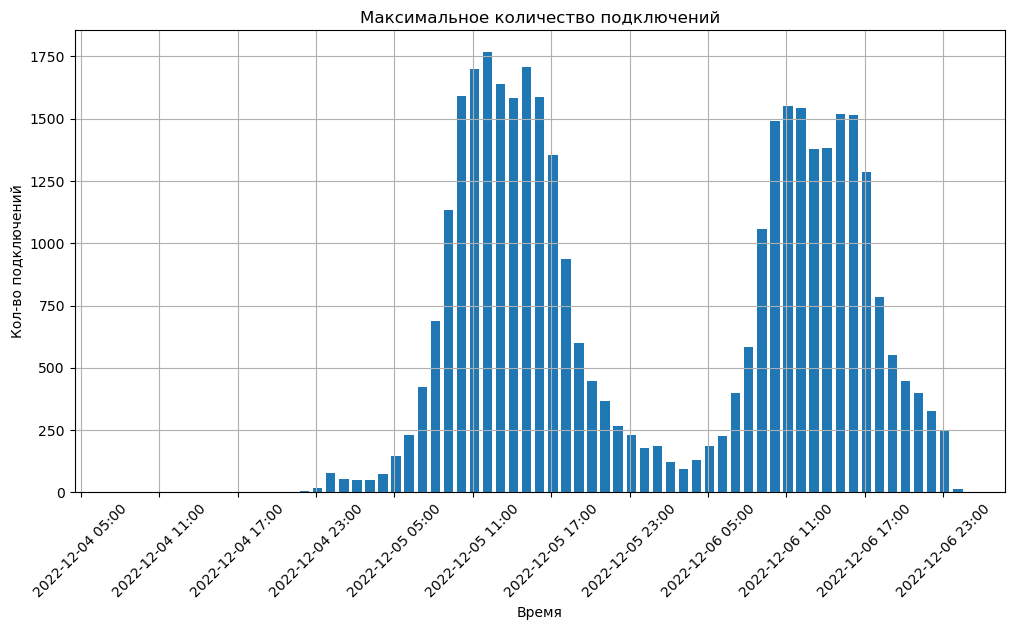

In [6]:
# Визуализация данных на графике
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(time_range[:-1], connections, width=0.03)

# Форматирование оси X
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

# Добавление сетки
plt.grid(True)

plt.title('Максимальное количество подключений')
plt.xlabel('Время')
plt.ylabel('Кол-во подключений')
plt.show()

### Вывод:
### Из графика можно увидеть, что во время пиковых нагрузок за рассматриваемый период мы не превышали установленный лимит в 3000 одновременных подключений.

### Посмотрим на длительность подключений:

In [7]:
# Расчет длительности соединения
df['duration'] = df['conn_end_time'] - df['start_edit_time']
# Добавление столбца с датой
df['date'] = df['start_edit_time'].dt.date

### Выясним среднюю, медиану и ноду интервалов подключений

In [8]:
# Создание столбца с интервалами подключений в секундах
df['connection_interval_seconds'] = (df['conn_end_time'] - df['start_edit_time']).dt.total_seconds()

# Функция для преобразования секунд в формат часы:минуты:секунды
def seconds_to_hms(seconds):
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    return f'{h:02d}:{m:02d}:{s:02d}'

# Вычисление среднего значения
mean_interval = df['connection_interval_seconds'].mean()

# Вычисление медианного значения
median_interval = df['connection_interval_seconds'].median()

# Вычисление моды
mode_interval = df['connection_interval_seconds'].mode().iloc[0]

print(f'Средний интервал подключения: {seconds_to_hms(mean_interval)}')
print(f'Медианный интервал подключения: {seconds_to_hms(median_interval)}')
print(f'Мода интервалов подключения: {seconds_to_hms(mode_interval)}')

Средний интервал подключения: 00:21:10
Медианный интервал подключения: 00:07:45
Мода интервалов подключения: 00:00:59


#### Посмотрим в разреде дат.

In [9]:
daily_avg_duration = df.groupby('date')['duration'].mean()
daily_avg_duration

date
2022-12-04   0 days 01:45:49.012345679
2022-12-05   0 days 00:21:31.119303934
2022-12-06   0 days 00:20:39.879969024
Name: duration, dtype: timedelta64[ns]

In [10]:
daily_median_duration = df.groupby('date')['duration'].median()
daily_median_duration

date
2022-12-04   0 days 00:50:31
2022-12-05   0 days 00:07:50
2022-12-06   0 days 00:07:38
Name: duration, dtype: timedelta64[ns]

In [11]:
daily_moda_duration = df.groupby('date')['connection_interval_seconds'].apply(lambda x: x.mode().iloc[0]).reset_index(name='moda_duration')

# Функция для преобразования секунд в формат часы:минуты:секунды
def seconds_to_hms(seconds):
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    return f'{h:02d}:{m:02d}:{s:02d}'

# Преобразование секунд в формат часы:минуты:секунды
daily_moda_duration['moda_duration_hms'] = daily_moda_duration['moda_duration'].apply(seconds_to_hms)

# Отображение таблицы
print(daily_moda_duration)

         date  moda_duration moda_duration_hms
0  2022-12-04          134.0          00:02:14
1  2022-12-05          116.0          00:01:56
2  2022-12-06           90.0          00:01:30


#### Среднее очень сильно отличается от медианы, скорее всего в данных множество значительных выбросов, которые сильно отклоняются от среднего времени.

### Построим диаграмму

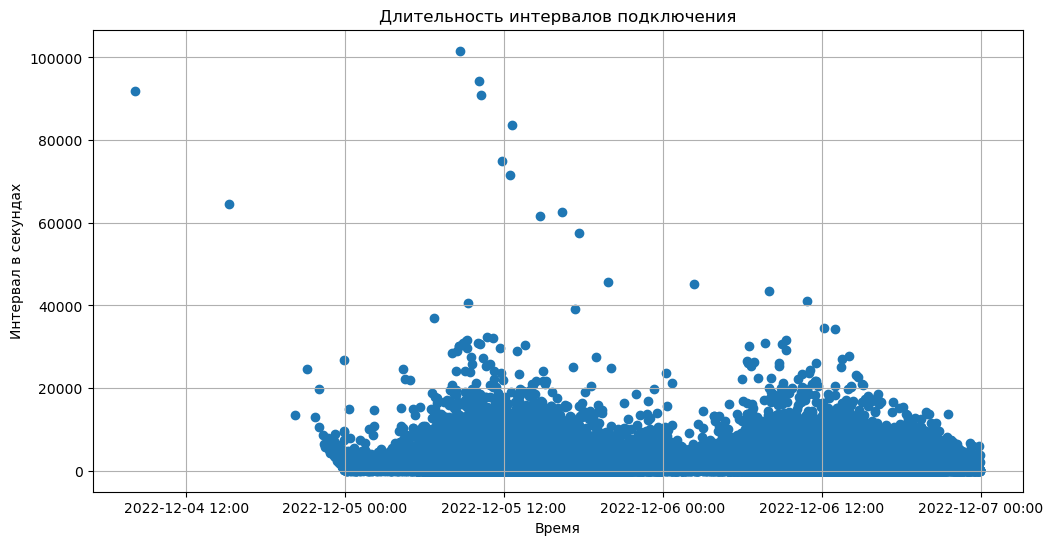

In [12]:

df['duration_seconds'] = df['duration'].dt.total_seconds()
plt.figure(figsize=(12, 6))
plt.scatter(df['start_edit_time'], df['duration_seconds'])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.title('Длительность интервалов подключения')
plt.xlabel('Время')
plt.ylabel('Интервал в секундах')
# Добавление сетки
plt.grid(True)
plt.show()

#### Диаграмма подтверждает наш вывод.

#### Выведем ТОП-20 по длительности интервалов.

In [35]:
# Группировка данных по дате и серверу и вычисление топ 10 интервалов подключения для каждой группы
top_10_by_date_and_server = df.groupby(['date', 'server'])['connection_interval_seconds'].apply(lambda x: x.nlargest(10)).reset_index(name='connection_interval')

# Сортировка таблицы по столбцу top_10_connection_interval_seconds по убыванию
top_10_by_date_and_server = top_10_by_date_and_server.sort_values(by='connection_interval', ascending=False)

# Удаление лишнего столбца
top_10_by_date_and_server = top_10_by_date_and_server.drop('level_2', axis=1)

# Функция для преобразования секунд в формат часы:минуты:секунды
def seconds_to_hms(seconds):
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    return f'{h:02d}:{m:02d}:{s:02d}'

# Преобразование секунд в формат часы:минуты:секунды
top_10_by_date_and_server['connection_interval_hms'] = top_10_by_date_and_server['connection_interval'].apply(seconds_to_hms)

# Удаление лишнего столбца
top_10_by_date_and_server = top_10_by_date_and_server.drop('connection_interval', axis=1)
top_10_by_date_and_server = top_10_by_date_and_server.reset_index(drop=True)
# Отображение таблицы
display(top_10_by_date_and_server.head(20))

,date,server,connection_interval_hms
0,2022-12-05,ms,28:13:42
1,2022-12-05,ru,26:10:04
2,2022-12-04,de,25:32:19
3,2022-12-05,ms,25:16:31
4,2022-12-05,ms,23:15:17
5,2022-12-05,ms,20:49:47
6,2022-12-05,ms,19:53:02
7,2022-12-04,de,17:57:22
8,2022-12-05,ms,17:23:58
9,2022-12-05,ru,17:06:10


### Вывод:
### В данных обнаружено множество значительных выбросов, которые сильно отклоняются от среднего времени. Это подтверждается большой разницей между нодой и медианой, которая также наблюдается на графике и в таблице. Если время работы с документом не превышает 9 часов, то это еще можно считать адекватным, однако, если время превышает это значение, то возможно автоматическое отключение от сервера не срабатывает, что создает дополнительную нагрузку на сервер.

### Рассмотрим распределение соединений по серверам и типам порталов, чтобы увидеть, есть ли какие-то закономерности или аномалии. Проверим, есть ли серверы или типы порталов с непропорционально высоким или низким количеством соединений.

In [37]:
connections_by_server_and_portal = df.groupby(['server', 'portal_type']).size().reset_index(name='connections')

# Отображение результатов
display(connections_by_server_and_portal)

,server,portal_type,connections
0,de,box,1938
1,de,cloud,12575
2,ms,box,11458
3,ms,cloud,34046
4,ru,cloud,29189
5,us,cloud,14278


#### В общем количесве подключений мы видим что максимальное количество подключений идет с серверов `ms` и `ru` и порталов типа `cloud`

In [28]:
connections_by_server_and_portal_and_date = df.groupby(['server', 'portal_type', df['start_edit_time'].dt.date]).size().reset_index(name='connections')

# Изменение порядка столбцов и сортировка таблицы по столбцу с датой
connections_by_server_and_portal_and_date = connections_by_server_and_portal_and_date[['start_edit_time', 'server', 'portal_type', 'connections']].sort_values(by=['start_edit_time', 'server'])
connections_by_server_and_portal_and_date = connections_by_server_and_portal_and_date.reset_index(drop=True)
# Отображение таблицы
display(connections_by_server_and_portal_and_date)

,start_edit_time,server,portal_type,connections
0,2022-12-04,de,box,4
1,2022-12-04,de,cloud,11
2,2022-12-04,ms,box,5
3,2022-12-04,ms,cloud,26
4,2022-12-04,ru,cloud,14
5,2022-12-04,us,cloud,21
6,2022-12-05,de,box,985
7,2022-12-05,de,cloud,6477
8,2022-12-05,ms,box,6012
9,2022-12-05,ms,cloud,17647


#### Тоже самое в разбивке по числам.

### Выведем не общее-кол во подключений, а максимальный объем одновременных подключений

In [16]:
# Создание временного DataFrame с начальными и конечными временами соединений
tmp_df = pd.melt(df, id_vars=['server', 'portal_type', 'date'], value_vars=['start_edit_time', 'conn_end_time'], value_name='time').sort_values('time')

# Подсчет количества активных соединений для каждого момента времени
tmp_df['active_connections'] = tmp_df.groupby(['server', 'portal_type', 'date'])['variable'].apply(lambda x: x.eq('start_edit_time').cumsum() - x.eq('conn_end_time').cumsum())

# Группировка данных по серверам, типам порталов и дате и вычисление максимального количества соединений для каждой группы
max_connections_by_server_and_portal_and_date = tmp_df.groupby(['server', 'portal_type', 'date'])['active_connections'].max().reset_index(name='max_connections')

# Сортировка таблицы по столбцам с датой и сервером
max_connections_by_server_and_portal_and_date = max_connections_by_server_and_portal_and_date.sort_values(by=['date', 'server'])

# Изменение порядка столбцов в таблице
max_connections_by_server_and_portal_and_date = max_connections_by_server_and_portal_and_date[['date', 'server', 'portal_type', 'max_connections']]
max_connections_by_server_and_portal_and_date = max_connections_by_server_and_portal_and_date.reset_index(drop=True)
# Отображение таблицы
display(max_connections_by_server_and_portal_and_date)

,date,server,portal_type,max_connections
0,2022-12-04,de,box,4.0
1,2022-12-04,de,cloud,11.0
2,2022-12-04,ms,box,5.0
3,2022-12-04,ms,cloud,26.0
4,2022-12-04,ru,cloud,14.0
5,2022-12-04,us,cloud,21.0
6,2022-12-05,de,box,51.0
7,2022-12-05,de,cloud,295.0
8,2022-12-05,ms,box,226.0
9,2022-12-05,ms,cloud,673.0


#### В разрезе максимального объема одновременных подключений мы видим что максимальное количество подключений идет с серверов `ms` и `ru` и порталов типа `cloud`

#### Отразим это с помощью столбчатой диаграммы

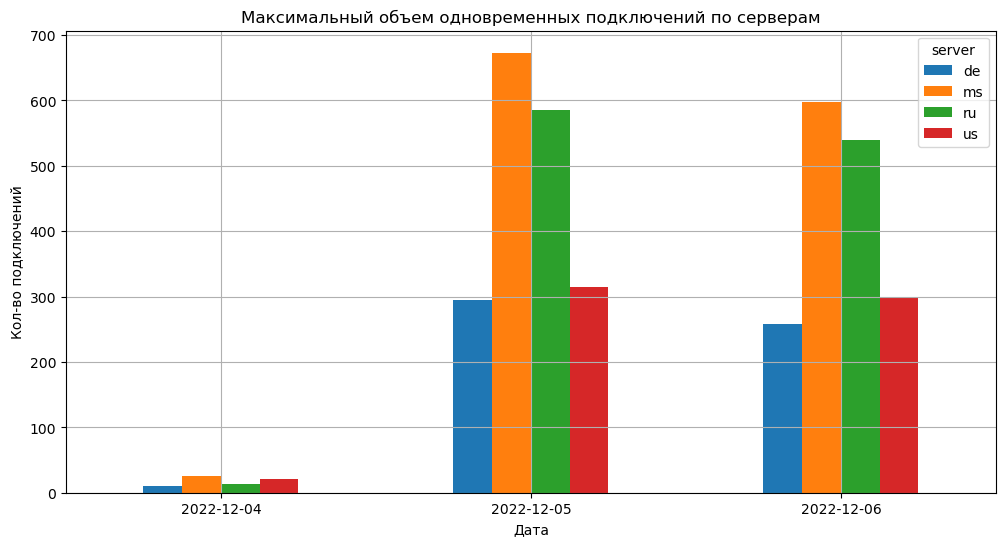

In [38]:
# Создание столбца с датой
df['date'] = df['start_edit_time'].dt.date

# Создание временного DataFrame с начальными и конечными временами соединений
tmp_df = pd.melt(df, id_vars=['server', 'portal_type', 'date'], value_vars=['start_edit_time', 'conn_end_time'], value_name='time').sort_values('time')

# Подсчет количества активных соединений для каждого момента времени
tmp_df['active_connections'] = tmp_df.groupby(['server', 'portal_type', 'date'])['variable'].apply(lambda x: x.eq('start_edit_time').cumsum() - x.eq('conn_end_time').cumsum())

# Группировка данных по серверам и дате и вычисление максимального количества соединений для каждой группы
max_connections_by_server_and_date = tmp_df.groupby(['server', 'date'])['active_connections'].max().reset_index(name='max_connections')

# Создание сводной таблицы с данными о максимальном количестве подключений в разбивке по серверам и датам
pivot_table = max_connections_by_server_and_date.pivot(index='date', columns='server', values='max_connections')

# Визуализация данных на графике
fig, ax = plt.subplots(figsize=(12, 6))
pivot_table.plot(kind='bar', ax=ax)
plt.title('Максимальный объем одновременных подключений по серверам')
plt.xlabel('Дата')
plt.ylabel('Кол-во подключений')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

### Вывод:
#### Мы можем заметить, что наибольшее количество одновременных подключений происходит с серверов `ms` и `ru`, а также с порталов типа `cloud`, если рассматривать максимальный объем подключений.

### Сравним нагрузки в разбивке по тарифам, так как их очень много возьмемм ТОП-10 по обьему подключений 

In [20]:
grouped = df.groupby('tariff_id').size().reset_index(name='count')

# Сортировка данных по убыванию количества записей и выбор топ 10 tariff_id
top_10 = grouped.sort_values('count', ascending=False).head(10)
top_10 = top_10.reset_index(drop=True)
# Вывод результата
display(top_10)

,tariff_id,count
0,ru_pro,28250
1,box,13396
2,ru_std,9208
3,ru_pro100,7128
4,ru_company,7076
5,ru_team_2019,6380
6,br_pro,2661
7,en_pro,2144
8,ru_nfr,2093
9,en_company,1595


#### В лидерах у нас тариф `ru_pro`. Сделаем таблицу с разбивкой по дням.

In [21]:
grouped = df.groupby([pd.Grouper(key='start_edit_time', freq='D'), 'tariff_id']).size().reset_index(name='count')

# Сортировка данных по убыванию количества записей и выбор топ 10 tariff_id с максимальным количеством подключений
top_10 = grouped.sort_values('count', ascending=False).head(10)

# Удаление столбца с индексами
top_10 = top_10.reset_index(drop=True)

# Вывод результата
display(top_10)

,start_edit_time,tariff_id,count
0,2022-12-05,ru_pro,14628
1,2022-12-06,ru_pro,13608
2,2022-12-05,box,6997
3,2022-12-06,box,6390
4,2022-12-05,ru_std,4730
5,2022-12-06,ru_std,4472
6,2022-12-05,ru_company,3685
7,2022-12-05,ru_pro100,3679
8,2022-12-06,ru_pro100,3444
9,2022-12-06,ru_company,3387


#### В разбивке по дням ситуация не изменилась. Выведем не общее-кол во подключений, а максимальный объем одновременных подключений с тарифа.

In [22]:
# Создание списка событий начала и завершения подключения
events = []
for _, row in df.iterrows():
    events.append((row['start_edit_time'].date(), row['start_edit_time'], row['tariff_id'], 1))
    events.append((row['conn_end_time'].date(), row['conn_end_time'], row['tariff_id'], -1))

# Сортировка списка событий по времени
events.sort(key=lambda x: x[1])

# Расчет максимального количества одновременных подключений для каждого tariff_id и каждой даты
max_connections = {}
connections = {}
for event in events:
    date, time, tariff_id, change = event
    if tariff_id not in connections:
        connections[tariff_id] = 0
    connections[tariff_id] += change
    if (date, tariff_id) not in max_connections:
        max_connections[(date, tariff_id)] = 0
    max_connections[(date, tariff_id)] = max(max_connections[(date, tariff_id)], connections[tariff_id])

# Создание DataFrame с результатами
result = pd.DataFrame([(date, tariff_id, max_conn) for (date, tariff_id), max_conn in max_connections.items()], columns=['date', 'tariff_id', 'max_connections'])

# Сортировка данных по убыванию максимального количества одновременных подключений и выбор топ 10 tariff_id
top_10 = result.sort_values('max_connections', ascending=False).head(10)
top_10 = top_10.reset_index(drop=True)
# Вывод результата
display(top_10)

,date,tariff_id,max_connections
0,2022-12-05,ru_pro,586
1,2022-12-06,ru_pro,504
2,2022-12-05,box,261
3,2022-12-06,box,240
4,2022-12-05,ru_std,201
5,2022-12-06,ru_std,182
6,2022-12-05,ru_pro100,168
7,2022-12-05,ru_company,145
8,2022-12-06,ru_company,138
9,2022-12-05,ru_team_2019,133


### Вывод:
#### Тариф `ru_pro` по прежнему в лидерах

## Общий вывод:
### В результате анализа мы увидели что:
* ###  До максимума допустимых лимитов одновременных подключений еще довольно далеко, но ситуацию на контроле держать надо
* ### Также мы можем заметить, что наибольшее количество одновременных подключений происходит с серверов `ms` и `ru`, а также с порталов типа `cloud`, если рассматривать максимальный объем подключений. И если нам будет необходимо уменьшать нагрузку нужно будет начинать с этих серверов и порталов.
* ### Наиболее нагруженый тарифы у нас `ru_pro`,`box` и `ru_std`
* ### Необходимо обратить внимание на срабатывание автоматического отключения, видимо иногда оно не срабатывает что содает дополнительную нагрузку на сервера компании.